# Create paper emulation figure


In [1]:
import os
## Ignore my broken HDF5 install...
os.putenv("HDF5_DISABLE_VERSION_CHECK", '1')

In [2]:
import iris

from utils import get_bc_ppe_data

from GCEm import cnn_model, gp_model
from GCEm.utils import get_random_params

import iris.quickplot as qplt
import iris.analysis.maths as imath
import matplotlib.pyplot as plt
%matplotlib inline

## Read in the parameters and data

In [3]:
ppe_params, ppe_aaod = get_bc_ppe_data()

/Users/watson-parris/miniconda3/envs/gcem/lib/python3.8/site-packages/iris/__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))
/Users/watson-parris/miniconda3/envs/gcem/lib/python3.8/site-packages/iris/__init__.py:249: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))


In [4]:
## Ensure thWetdepnumbertime dimension is last - this is treated as the color 'channel'
## ppe_aaod.transpose((0,2,3,1))
ppe_aaod = ppe_aaod.collapsed('time')[0]

In [5]:
n_test = 5

X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
Y_test, Y_train = ppe_aaod[:n_test], ppe_aaod[n_test:]

In [6]:
Y_train

<iris 'Cube' of Absorption optical thickness - total 550nm / (1) (job: 34; latitude: 96; longitude: 192)>

## Setup and run the models

In [7]:
nn_model = cnn_model(X_train, Y_train)

In [8]:
nn_model.model.model.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 221184)            884736    
_________________________________________________________________
reshape (Reshape)            (None, 96, 192, 12)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 96, 192, 12)       2172      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 96, 192, 1)        181       
Total params: 887,089
Trainable params: 887,089
Non-trainable params: 0
_________________________________________________________________


In [9]:
nn_model.train()

Epoch 1/100
4/4 [==============================] - 1s 284ms/step - loss: 0.8766 - val_loss: 0.4800
Epoch 2/100
4/4 [==============================] - 0s 115ms/step - loss: 1.0869 - val_loss: 0.4778
Epoch 3/100
4/4 [==============================] - 0s 100ms/step - loss: 1.1900 - val_loss: 0.4759
Epoch 4/100
4/4 [==============================] - 0s 106ms/step - loss: 1.0656 - val_loss: 0.4741
Epoch 5/100
4/4 [==============================] - 0s 99ms/step - loss: 1.2058 - val_loss: 0.4699
Epoch 6/100
4/4 [==============================] - 0s 112ms/step - loss: 1.2211 - val_loss: 0.4672
Epoch 7/100
4/4 [==============================] - 0s 105ms/step - loss: 1.0138 - val_loss: 0.4624
Epoch 8/100
4/4 [==============================] - 0s 101ms/step - loss: 0.9261 - val_loss: 0.4645
Epoch 9/100
4/4 [==============================] - 0s 112ms/step - loss: 0.9354 - val_loss: 0.4569
Epoch 10/100
4/4 [==============================] - 0s 100ms/step - loss: 1.1767 - val_loss: 0.4494
Epoch 11/1

In [10]:
## Linear model:  0.3566 - val_loss: 0.0867

In [11]:
nn_prediction, _ = nn_model.predict(X_test.values)

In [12]:
gp_model_ = gp_model(X_train, Y_train, kernel=['Bias', 'Linear'])
gp_model_.train()

In [13]:
gp_prediction, _ = gp_model_.predict(X_test.values)

/Users/watson-parris/miniconda3/envs/gcem/lib/python3.8/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'sample'.
  warnings.warn(msg.format(self.name()))
/Users/watson-parris/miniconda3/envs/gcem/lib/python3.8/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'sample'.
  warnings.warn(msg.format(self.name()))


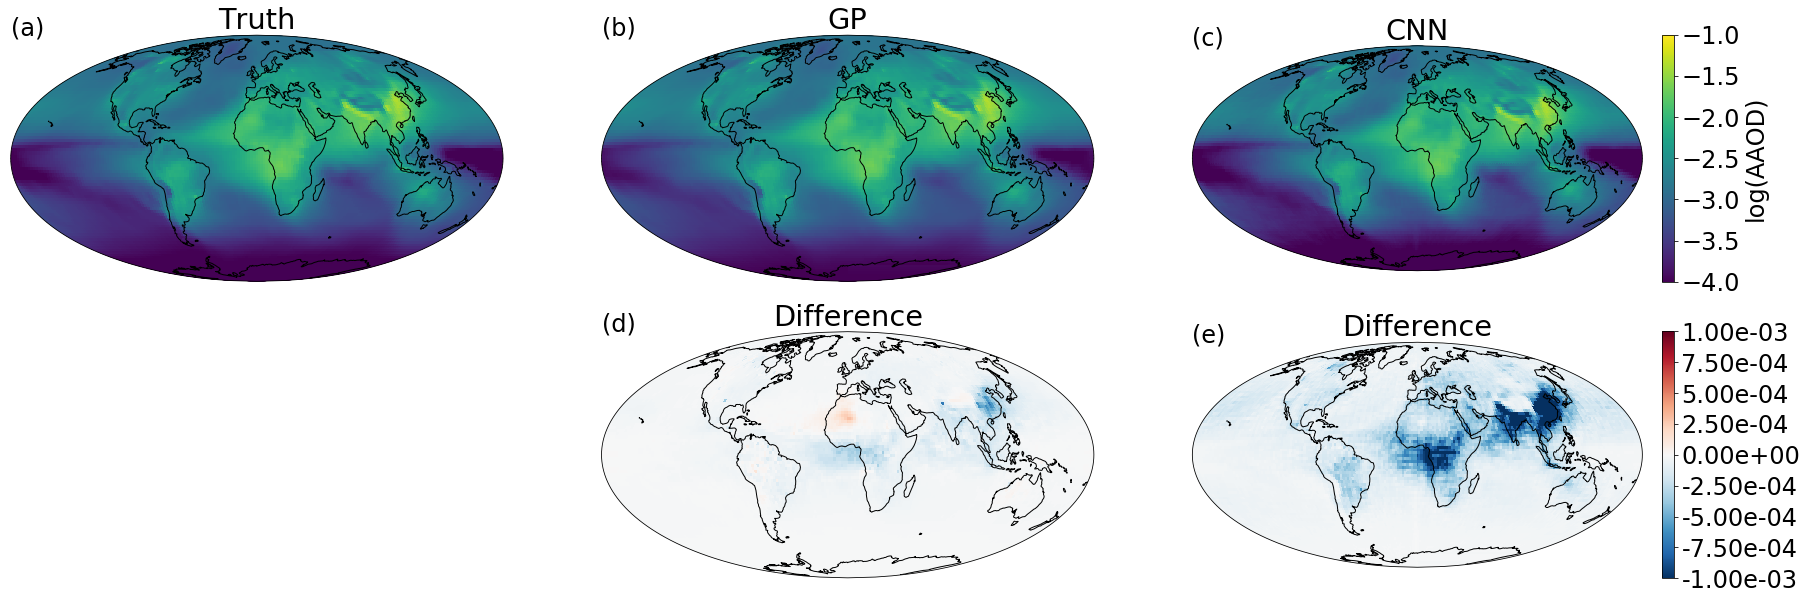

In [14]:
import matplotlib 
import cartopy.crs as ccrs
import iris.plot as iplt


plt.figure(figsize=(30, 10))
matplotlib.rcParams['font.size'] = 24

plt.subplot(2,3,1, projection=ccrs.Mollweide())
plt.annotate("(a)", (0.,1.), xycoords='axes fraction')
iplt.pcolormesh(imath.log10(Y_test[0]), vmin=-4, vmax=-1)
plt.gca().set_title('Truth')
plt.gca().coastlines()

plt.subplot(2,3,2, projection=ccrs.Mollweide())
plt.annotate("(b)", (0.,1.), xycoords='axes fraction')
iplt.pcolormesh(imath.log10(gp_prediction[0]), vmin=-4, vmax=-1)
plt.gca().set_title('GP')
plt.gca().coastlines()

plt.subplot(2,3,3, projection=ccrs.Mollweide())
plt.annotate("(c)", (0.,1.), xycoords='axes fraction')
im=iplt.pcolormesh(imath.log10(nn_prediction[0]), vmin=-4, vmax=-1)
plt.gca().set_title('CNN')
plt.colorbar(im, fraction=0.046, pad=0.04, label='log(AAOD)')
plt.gca().coastlines()

plt.subplot(2,3,5, projection=ccrs.Mollweide())
plt.annotate("(d)", (0.,1.), xycoords='axes fraction')
iplt.pcolormesh((gp_prediction.collapsed(['sample'], iris.analysis.MEAN)-Y_test.collapsed(['job'], iris.analysis.MEAN)), cmap='RdBu_r', vmin=-0.001, vmax=0.001)
plt.gca().coastlines()
plt.gca().set_title('Difference')

plt.subplot(2,3,6, projection=ccrs.Mollweide())
plt.annotate("(e)", (0.,1.), xycoords='axes fraction')
im=iplt.pcolormesh((nn_prediction.collapsed(['sample'], iris.analysis.MEAN)-Y_test.collapsed(['job'], iris.analysis.MEAN)), cmap='RdBu_r', vmin=-1e-3, vmax=1e-3)
cb = plt.colorbar(im, fraction=0.046, pad=0.04)
cb.ax.set_yticklabels(["{:.2e}".format(i) for i in cb.get_ticks()]) ## set ticks of your format
plt.gca().coastlines()
plt.gca().set_title('Difference')

plt.savefig('BCPPE_emulator_paper.png', transparent=True)

/Users/watson-parris/miniconda3/envs/gcem/lib/python3.8/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'sample'.
  warnings.warn(msg.format(self.name()))
/Users/watson-parris/miniconda3/envs/gcem/lib/python3.8/site-packages/iris/coords.py:1410: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'sample'.
  warnings.warn(msg.format(self.name()))


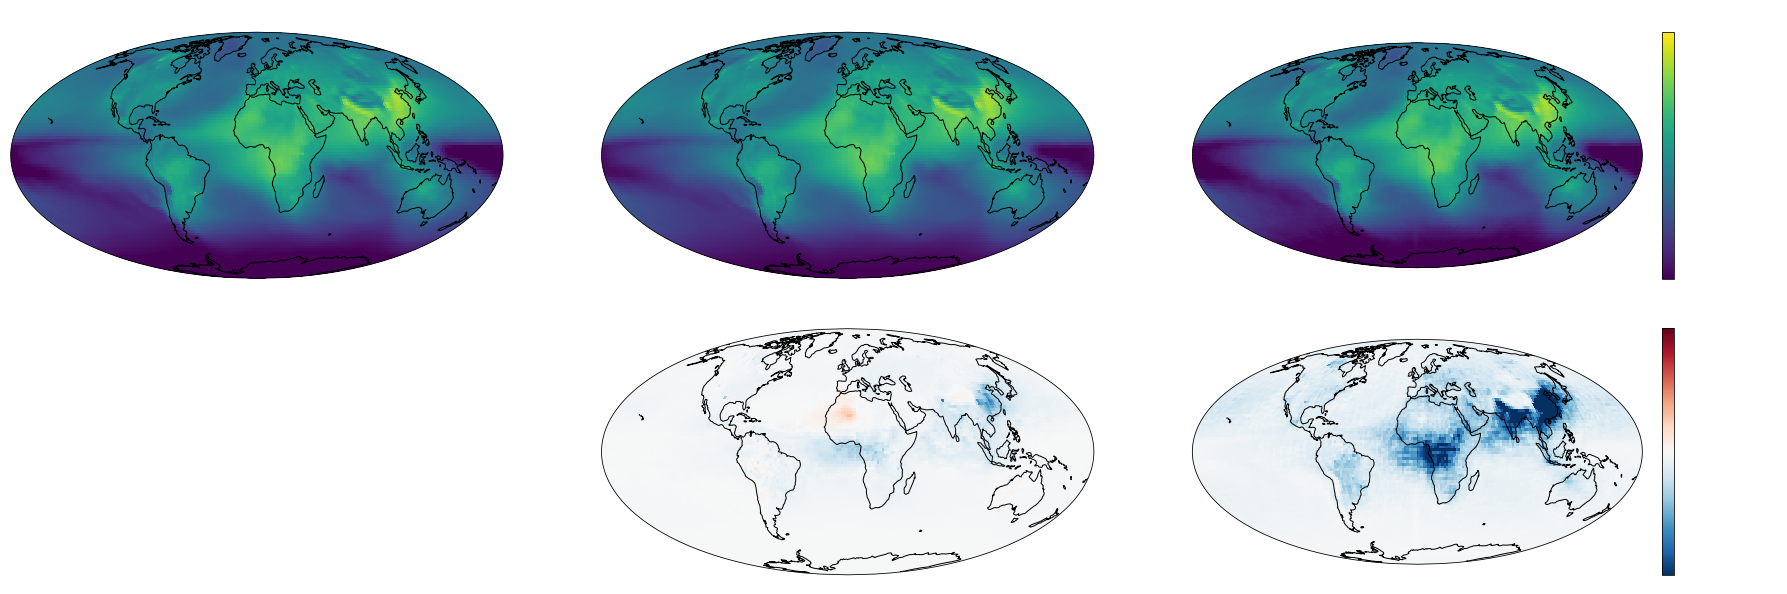

In [15]:

COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['font.size'] = 20

plt.figure(figsize=(30, 10))

plt.subplot(2,3,1, projection=ccrs.Mollweide())
plt.annotate("(a)", (0.,1.), xycoords='axes fraction')
iplt.pcolormesh(imath.log10(Y_test[0]), vmin=-4, vmax=-1)
plt.gca().set_title('Truth')
plt.gca().coastlines()

plt.subplot(2,3,2, projection=ccrs.Mollweide())
plt.annotate("(b)", (0.,1.), xycoords='axes fraction')
iplt.pcolormesh(imath.log10(gp_prediction[0]), vmin=-4, vmax=-1)
plt.gca().set_title('GP')
plt.gca().coastlines()

plt.subplot(2,3,3, projection=ccrs.Mollweide())
plt.annotate("(c)", (0.,1.), xycoords='axes fraction')
im=iplt.pcolormesh(imath.log10(nn_prediction[0]), vmin=-4, vmax=-1)
plt.gca().set_title('CNN')
plt.colorbar(im, fraction=0.046, pad=0.04, label='log(AAOD)')
plt.gca().coastlines()

plt.subplot(2,3,5, projection=ccrs.Mollweide())
plt.annotate("(d)", (0.,1.), xycoords='axes fraction')
iplt.pcolormesh((gp_prediction.collapsed(['sample'], iris.analysis.MEAN)-Y_test.collapsed(['job'], iris.analysis.MEAN)), cmap='RdBu_r', vmin=-0.001, vmax=0.001)
plt.gca().coastlines()
plt.gca().set_title('Difference')

plt.subplot(2,3,6, projection=ccrs.Mollweide())
plt.annotate("(e)", (0.,1.), xycoords='axes fraction')
im=iplt.pcolormesh((nn_prediction.collapsed(['sample'], iris.analysis.MEAN)-Y_test.collapsed(['job'], iris.analysis.MEAN)), cmap='RdBu_r', vmin=-1e-3, vmax=1e-3)
cb=plt.colorbar(im, fraction=0.046, pad=0.04)
cb.ax.set_yticklabels(["{:.2e}".format(i) for i in cb.get_ticks()]) ## set ticks of your format
plt.gca().coastlines()
plt.gca().set_title('Difference')

plt.savefig('BCPPE_emulator_talk.png', transparent=True)